# Pipeline

In [122]:
import pandas as pd
import matplotlib.pyplot as plt

### Data input

In [123]:
import pandas as pd

# Importing the dataset
df = pd.read_csv('data/creditcard.csv')
df = df.drop(['Time'], axis=1)
df.reset_index(drop=True, inplace=True)

### Data preprocessing

### Model hyperparameter tuning

In [124]:
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, make_scorer 

pipeline = make_pipeline(
    RobustScaler(),
    SelectKBest(),
    LogisticRegression()
)

params_grid = {
    'selectkbest__k': [5, 15, 25],
    'logisticregression__C': [ 0.1, 1, 5],
    'logisticregression__solver': ['lbfgs', 'liblinear'],
}

As the data set in really unbalanced, we will use the F1 score as the metric to evaluate the model performance.

In [125]:
from sklearn.model_selection import train_test_split
f1_score_list = []
k=10
for _ in range(k):
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(df.drop(['Class'], axis=1), df['Class'], test_size=0.2)
    
    # Train model
    grid = GridSearchCV(pipeline, param_grid=params_grid, cv=4, scoring="f1", verbose=3)
    grid.fit(X_train, y_train)
    model = grid.best_estimator_
    model.fit(X_train, y_train)

    # Evaluate model
    y_pred = pd.DataFrame(model.predict_proba(X_test)[:,-1].round())
    y_test = pd.DataFrame(y_test)
    f1_score_list.append(f1_score(y_test, y_pred))

print(f"The average f1 score for {k} is: ", sum(f1_score_list)/k)


Fitting 4 folds for each of 18 candidates, totalling 72 fits
[CV 1/4] END logisticregression__C=0.1, logisticregression__solver=lbfgs, selectkbest__k=5;, score=0.738 total time=   0.4s
[CV 2/4] END logisticregression__C=0.1, logisticregression__solver=lbfgs, selectkbest__k=5;, score=0.702 total time=   0.4s
[CV 3/4] END logisticregression__C=0.1, logisticregression__solver=lbfgs, selectkbest__k=5;, score=0.646 total time=   0.3s
[CV 4/4] END logisticregression__C=0.1, logisticregression__solver=lbfgs, selectkbest__k=5;, score=0.704 total time=   0.3s
[CV 1/4] END logisticregression__C=0.1, logisticregression__solver=lbfgs, selectkbest__k=15;, score=0.786 total time=   0.5s
[CV 2/4] END logisticregression__C=0.1, logisticregression__solver=lbfgs, selectkbest__k=15;, score=0.718 total time=   0.5s
[CV 3/4] END logisticregression__C=0.1, logisticregression__solver=lbfgs, selectkbest__k=15;, score=0.679 total time=   0.5s
[CV 4/4] END logisticregression__C=0.1, logisticregression__solver=l

c:\Users\cleme\Desktop\personal-projects\ml-personal-train\venv\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/4] END logisticregression__C=1, logisticregression__solver=lbfgs, selectkbest__k=25;, score=0.786 total time=   1.2s


c:\Users\cleme\Desktop\personal-projects\ml-personal-train\venv\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/4] END logisticregression__C=1, logisticregression__solver=lbfgs, selectkbest__k=25;, score=0.724 total time=   1.2s
[CV 3/4] END logisticregression__C=1, logisticregression__solver=lbfgs, selectkbest__k=25;, score=0.675 total time=   1.1s
[CV 4/4] END logisticregression__C=1, logisticregression__solver=lbfgs, selectkbest__k=25;, score=0.727 total time=   1.2s
[CV 1/4] END logisticregression__C=1, logisticregression__solver=liblinear, selectkbest__k=5;, score=0.738 total time=   0.6s
[CV 2/4] END logisticregression__C=1, logisticregression__solver=liblinear, selectkbest__k=5;, score=0.702 total time=   0.5s
[CV 3/4] END logisticregression__C=1, logisticregression__solver=liblinear, selectkbest__k=5;, score=0.646 total time=   0.5s
[CV 4/4] END logisticregression__C=1, logisticregression__solver=liblinear, selectkbest__k=5;, score=0.704 total time=   0.5s
[CV 1/4] END logisticregression__C=1, logisticregression__solver=liblinear, selectkbest__k=15;, score=0.786 total time=   0.9s


c:\Users\cleme\Desktop\personal-projects\ml-personal-train\venv\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/4] END logisticregression__C=5, logisticregression__solver=lbfgs, selectkbest__k=25;, score=0.779 total time=   3.3s


c:\Users\cleme\Desktop\personal-projects\ml-personal-train\venv\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/4] END logisticregression__C=5, logisticregression__solver=lbfgs, selectkbest__k=25;, score=0.724 total time=   3.2s
[CV 3/4] END logisticregression__C=5, logisticregression__solver=lbfgs, selectkbest__k=25;, score=0.675 total time=   2.9s
[CV 4/4] END logisticregression__C=5, logisticregression__solver=lbfgs, selectkbest__k=25;, score=0.727 total time=   2.2s
[CV 1/4] END logisticregression__C=5, logisticregression__solver=liblinear, selectkbest__k=5;, score=0.738 total time=   0.9s
[CV 2/4] END logisticregression__C=5, logisticregression__solver=liblinear, selectkbest__k=5;, score=0.702 total time=   0.8s
[CV 3/4] END logisticregression__C=5, logisticregression__solver=liblinear, selectkbest__k=5;, score=0.646 total time=   1.8s
[CV 4/4] END logisticregression__C=5, logisticregression__solver=liblinear, selectkbest__k=5;, score=0.708 total time=   0.4s
[CV 1/4] END logisticregression__C=5, logisticregression__solver=liblinear, selectkbest__k=15;, score=0.786 total time=   0.8s


c:\Users\cleme\Desktop\personal-projects\ml-personal-train\venv\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/4] END logisticregression__C=0.1, logisticregression__solver=lbfgs, selectkbest__k=25;, score=0.723 total time=   1.2s
[CV 2/4] END logisticregression__C=0.1, logisticregression__solver=lbfgs, selectkbest__k=25;, score=0.740 total time=   1.2s
[CV 3/4] END logisticregression__C=0.1, logisticregression__solver=lbfgs, selectkbest__k=25;, score=0.757 total time=   1.0s
[CV 4/4] END logisticregression__C=0.1, logisticregression__solver=lbfgs, selectkbest__k=25;, score=0.775 total time=   1.2s
[CV 1/4] END logisticregression__C=0.1, logisticregression__solver=liblinear, selectkbest__k=5;, score=0.679 total time=   0.5s
[CV 2/4] END logisticregression__C=0.1, logisticregression__solver=liblinear, selectkbest__k=5;, score=0.720 total time=   0.5s
[CV 3/4] END logisticregression__C=0.1, logisticregression__solver=liblinear, selectkbest__k=5;, score=0.747 total time=   0.4s
[CV 4/4] END logisticregression__C=0.1, logisticregression__solver=liblinear, selectkbest__k=5;, score=0.726 total t

c:\Users\cleme\Desktop\personal-projects\ml-personal-train\venv\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/4] END logisticregression__C=1, logisticregression__solver=lbfgs, selectkbest__k=25;, score=0.723 total time=   1.1s


c:\Users\cleme\Desktop\personal-projects\ml-personal-train\venv\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/4] END logisticregression__C=1, logisticregression__solver=lbfgs, selectkbest__k=25;, score=0.740 total time=   1.3s


c:\Users\cleme\Desktop\personal-projects\ml-personal-train\venv\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/4] END logisticregression__C=1, logisticregression__solver=lbfgs, selectkbest__k=25;, score=0.753 total time=   1.2s


c:\Users\cleme\Desktop\personal-projects\ml-personal-train\venv\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/4] END logisticregression__C=1, logisticregression__solver=lbfgs, selectkbest__k=25;, score=0.770 total time=   1.2s
[CV 1/4] END logisticregression__C=1, logisticregression__solver=liblinear, selectkbest__k=5;, score=0.679 total time=   0.4s
[CV 2/4] END logisticregression__C=1, logisticregression__solver=liblinear, selectkbest__k=5;, score=0.736 total time=   0.4s
[CV 3/4] END logisticregression__C=1, logisticregression__solver=liblinear, selectkbest__k=5;, score=0.743 total time=   0.4s
[CV 4/4] END logisticregression__C=1, logisticregression__solver=liblinear, selectkbest__k=5;, score=0.738 total time=   0.4s
[CV 1/4] END logisticregression__C=1, logisticregression__solver=liblinear, selectkbest__k=15;, score=0.707 total time=   0.9s
[CV 2/4] END logisticregression__C=1, logisticregression__solver=liblinear, selectkbest__k=15;, score=0.733 total time=   0.9s
[CV 3/4] END logisticregression__C=1, logisticregression__solver=liblinear, selectkbest__k=15;, score=0.784 total time=

c:\Users\cleme\Desktop\personal-projects\ml-personal-train\venv\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/4] END logisticregression__C=5, logisticregression__solver=lbfgs, selectkbest__k=25;, score=0.723 total time=   1.3s


c:\Users\cleme\Desktop\personal-projects\ml-personal-train\venv\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/4] END logisticregression__C=5, logisticregression__solver=lbfgs, selectkbest__k=25;, score=0.740 total time=   1.4s


c:\Users\cleme\Desktop\personal-projects\ml-personal-train\venv\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/4] END logisticregression__C=5, logisticregression__solver=lbfgs, selectkbest__k=25;, score=0.753 total time=   1.2s


c:\Users\cleme\Desktop\personal-projects\ml-personal-train\venv\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/4] END logisticregression__C=5, logisticregression__solver=lbfgs, selectkbest__k=25;, score=0.770 total time=   1.3s
[CV 1/4] END logisticregression__C=5, logisticregression__solver=liblinear, selectkbest__k=5;, score=0.687 total time=   0.4s
[CV 2/4] END logisticregression__C=5, logisticregression__solver=liblinear, selectkbest__k=5;, score=0.736 total time=   0.6s
[CV 3/4] END logisticregression__C=5, logisticregression__solver=liblinear, selectkbest__k=5;, score=0.738 total time=   0.4s
[CV 4/4] END logisticregression__C=5, logisticregression__solver=liblinear, selectkbest__k=5;, score=0.738 total time=   0.4s
[CV 1/4] END logisticregression__C=5, logisticregression__solver=liblinear, selectkbest__k=15;, score=0.707 total time=   0.9s
[CV 2/4] END logisticregression__C=5, logisticregression__solver=liblinear, selectkbest__k=15;, score=0.741 total time=   0.9s
[CV 3/4] END logisticregression__C=5, logisticregression__solver=liblinear, selectkbest__k=15;, score=0.784 total time=

c:\Users\cleme\Desktop\personal-projects\ml-personal-train\venv\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\cleme\Desktop\personal-projects\ml-personal-train\venv\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://s

Fitting 4 folds for each of 18 candidates, totalling 72 fits
[CV 1/4] END logisticregression__C=0.1, logisticregression__solver=lbfgs, selectkbest__k=5;, score=0.711 total time=   0.4s
[CV 2/4] END logisticregression__C=0.1, logisticregression__solver=lbfgs, selectkbest__k=5;, score=0.671 total time=   0.3s
[CV 3/4] END logisticregression__C=0.1, logisticregression__solver=lbfgs, selectkbest__k=5;, score=0.709 total time=   0.3s
[CV 4/4] END logisticregression__C=0.1, logisticregression__solver=lbfgs, selectkbest__k=5;, score=0.646 total time=   0.3s
[CV 1/4] END logisticregression__C=0.1, logisticregression__solver=lbfgs, selectkbest__k=15;, score=0.707 total time=   0.5s
[CV 2/4] END logisticregression__C=0.1, logisticregression__solver=lbfgs, selectkbest__k=15;, score=0.662 total time=   0.5s
[CV 3/4] END logisticregression__C=0.1, logisticregression__solver=lbfgs, selectkbest__k=15;, score=0.717 total time=   0.6s
[CV 4/4] END logisticregression__C=0.1, logisticregression__solver=l

c:\Users\cleme\Desktop\personal-projects\ml-personal-train\venv\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/4] END logisticregression__C=0.1, logisticregression__solver=lbfgs, selectkbest__k=25;, score=0.650 total time=   1.3s
[CV 3/4] END logisticregression__C=0.1, logisticregression__solver=lbfgs, selectkbest__k=25;, score=0.728 total time=   1.3s
[CV 4/4] END logisticregression__C=0.1, logisticregression__solver=lbfgs, selectkbest__k=25;, score=0.683 total time=   1.4s
[CV 1/4] END logisticregression__C=0.1, logisticregression__solver=liblinear, selectkbest__k=5;, score=0.699 total time=   0.6s
[CV 2/4] END logisticregression__C=0.1, logisticregression__solver=liblinear, selectkbest__k=5;, score=0.675 total time=   0.5s
[CV 3/4] END logisticregression__C=0.1, logisticregression__solver=liblinear, selectkbest__k=5;, score=0.725 total time=   0.4s
[CV 4/4] END logisticregression__C=0.1, logisticregression__solver=liblinear, selectkbest__k=5;, score=0.637 total time=   0.4s
[CV 1/4] END logisticregression__C=0.1, logisticregression__solver=liblinear, selectkbest__k=15;, score=0.695 tot

c:\Users\cleme\Desktop\personal-projects\ml-personal-train\venv\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/4] END logisticregression__C=1, logisticregression__solver=lbfgs, selectkbest__k=25;, score=0.691 total time=   1.2s


c:\Users\cleme\Desktop\personal-projects\ml-personal-train\venv\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/4] END logisticregression__C=1, logisticregression__solver=lbfgs, selectkbest__k=25;, score=0.646 total time=   1.2s
[CV 3/4] END logisticregression__C=1, logisticregression__solver=lbfgs, selectkbest__k=25;, score=0.724 total time=   1.3s


c:\Users\cleme\Desktop\personal-projects\ml-personal-train\venv\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/4] END logisticregression__C=1, logisticregression__solver=lbfgs, selectkbest__k=25;, score=0.683 total time=   1.3s
[CV 1/4] END logisticregression__C=1, logisticregression__solver=liblinear, selectkbest__k=5;, score=0.711 total time=   0.6s
[CV 2/4] END logisticregression__C=1, logisticregression__solver=liblinear, selectkbest__k=5;, score=0.671 total time=   0.4s
[CV 3/4] END logisticregression__C=1, logisticregression__solver=liblinear, selectkbest__k=5;, score=0.717 total time=   0.5s
[CV 4/4] END logisticregression__C=1, logisticregression__solver=liblinear, selectkbest__k=5;, score=0.646 total time=   0.5s
[CV 1/4] END logisticregression__C=1, logisticregression__solver=liblinear, selectkbest__k=15;, score=0.715 total time=   0.9s
[CV 2/4] END logisticregression__C=1, logisticregression__solver=liblinear, selectkbest__k=15;, score=0.662 total time=   1.0s
[CV 3/4] END logisticregression__C=1, logisticregression__solver=liblinear, selectkbest__k=15;, score=0.717 total time=

c:\Users\cleme\Desktop\personal-projects\ml-personal-train\venv\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/4] END logisticregression__C=5, logisticregression__solver=lbfgs, selectkbest__k=25;, score=0.683 total time=   1.4s
[CV 1/4] END logisticregression__C=5, logisticregression__solver=liblinear, selectkbest__k=5;, score=0.711 total time=   0.6s
[CV 2/4] END logisticregression__C=5, logisticregression__solver=liblinear, selectkbest__k=5;, score=0.671 total time=   0.4s
[CV 3/4] END logisticregression__C=5, logisticregression__solver=liblinear, selectkbest__k=5;, score=0.717 total time=   0.5s
[CV 4/4] END logisticregression__C=5, logisticregression__solver=liblinear, selectkbest__k=5;, score=0.646 total time=   0.5s
[CV 1/4] END logisticregression__C=5, logisticregression__solver=liblinear, selectkbest__k=15;, score=0.715 total time=   1.0s
[CV 2/4] END logisticregression__C=5, logisticregression__solver=liblinear, selectkbest__k=15;, score=0.662 total time=   1.0s
[CV 3/4] END logisticregression__C=5, logisticregression__solver=liblinear, selectkbest__k=15;, score=0.725 total time=

c:\Users\cleme\Desktop\personal-projects\ml-personal-train\venv\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/4] END logisticregression__C=1, logisticregression__solver=lbfgs, selectkbest__k=25;, score=0.726 total time=   1.3s


c:\Users\cleme\Desktop\personal-projects\ml-personal-train\venv\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/4] END logisticregression__C=1, logisticregression__solver=lbfgs, selectkbest__k=25;, score=0.754 total time=   1.2s
[CV 3/4] END logisticregression__C=1, logisticregression__solver=lbfgs, selectkbest__k=25;, score=0.759 total time=   1.2s


c:\Users\cleme\Desktop\personal-projects\ml-personal-train\venv\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/4] END logisticregression__C=1, logisticregression__solver=lbfgs, selectkbest__k=25;, score=0.719 total time=   1.3s
[CV 1/4] END logisticregression__C=1, logisticregression__solver=liblinear, selectkbest__k=5;, score=0.703 total time=   0.6s
[CV 2/4] END logisticregression__C=1, logisticregression__solver=liblinear, selectkbest__k=5;, score=0.743 total time=   0.5s
[CV 3/4] END logisticregression__C=1, logisticregression__solver=liblinear, selectkbest__k=5;, score=0.714 total time=   0.4s
[CV 4/4] END logisticregression__C=1, logisticregression__solver=liblinear, selectkbest__k=5;, score=0.739 total time=   0.5s
[CV 1/4] END logisticregression__C=1, logisticregression__solver=liblinear, selectkbest__k=15;, score=0.723 total time=   0.9s
[CV 2/4] END logisticregression__C=1, logisticregression__solver=liblinear, selectkbest__k=15;, score=0.736 total time=   1.0s
[CV 3/4] END logisticregression__C=1, logisticregression__solver=liblinear, selectkbest__k=15;, score=0.749 total time=

c:\Users\cleme\Desktop\personal-projects\ml-personal-train\venv\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/4] END logisticregression__C=5, logisticregression__solver=lbfgs, selectkbest__k=25;, score=0.726 total time=   1.3s


c:\Users\cleme\Desktop\personal-projects\ml-personal-train\venv\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/4] END logisticregression__C=5, logisticregression__solver=lbfgs, selectkbest__k=25;, score=0.750 total time=   1.3s
[CV 3/4] END logisticregression__C=5, logisticregression__solver=lbfgs, selectkbest__k=25;, score=0.759 total time=   1.2s


c:\Users\cleme\Desktop\personal-projects\ml-personal-train\venv\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/4] END logisticregression__C=5, logisticregression__solver=lbfgs, selectkbest__k=25;, score=0.726 total time=   1.3s
[CV 1/4] END logisticregression__C=5, logisticregression__solver=liblinear, selectkbest__k=5;, score=0.703 total time=   0.5s
[CV 2/4] END logisticregression__C=5, logisticregression__solver=liblinear, selectkbest__k=5;, score=0.743 total time=   0.5s
[CV 3/4] END logisticregression__C=5, logisticregression__solver=liblinear, selectkbest__k=5;, score=0.714 total time=   0.5s
[CV 4/4] END logisticregression__C=5, logisticregression__solver=liblinear, selectkbest__k=5;, score=0.739 total time=   0.5s
[CV 1/4] END logisticregression__C=5, logisticregression__solver=liblinear, selectkbest__k=15;, score=0.723 total time=   1.0s
[CV 2/4] END logisticregression__C=5, logisticregression__solver=liblinear, selectkbest__k=15;, score=0.736 total time=   1.0s
[CV 3/4] END logisticregression__C=5, logisticregression__solver=liblinear, selectkbest__k=15;, score=0.749 total time=

c:\Users\cleme\Desktop\personal-projects\ml-personal-train\venv\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/4] END logisticregression__C=1, logisticregression__solver=lbfgs, selectkbest__k=25;, score=0.763 total time=   1.2s


c:\Users\cleme\Desktop\personal-projects\ml-personal-train\venv\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/4] END logisticregression__C=1, logisticregression__solver=lbfgs, selectkbest__k=25;, score=0.675 total time=   1.3s


c:\Users\cleme\Desktop\personal-projects\ml-personal-train\venv\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/4] END logisticregression__C=1, logisticregression__solver=lbfgs, selectkbest__k=25;, score=0.778 total time=   1.5s


c:\Users\cleme\Desktop\personal-projects\ml-personal-train\venv\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/4] END logisticregression__C=1, logisticregression__solver=lbfgs, selectkbest__k=25;, score=0.782 total time=   1.2s
[CV 1/4] END logisticregression__C=1, logisticregression__solver=liblinear, selectkbest__k=5;, score=0.726 total time=   0.5s
[CV 2/4] END logisticregression__C=1, logisticregression__solver=liblinear, selectkbest__k=5;, score=0.687 total time=   0.6s
[CV 3/4] END logisticregression__C=1, logisticregression__solver=liblinear, selectkbest__k=5;, score=0.743 total time=   0.6s
[CV 4/4] END logisticregression__C=1, logisticregression__solver=liblinear, selectkbest__k=5;, score=0.734 total time=   0.5s
[CV 1/4] END logisticregression__C=1, logisticregression__solver=liblinear, selectkbest__k=15;, score=0.757 total time=   1.1s
[CV 2/4] END logisticregression__C=1, logisticregression__solver=liblinear, selectkbest__k=15;, score=0.683 total time=   1.0s
[CV 3/4] END logisticregression__C=1, logisticregression__solver=liblinear, selectkbest__k=15;, score=0.796 total time=

c:\Users\cleme\Desktop\personal-projects\ml-personal-train\venv\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/4] END logisticregression__C=5, logisticregression__solver=lbfgs, selectkbest__k=25;, score=0.763 total time=   1.2s


c:\Users\cleme\Desktop\personal-projects\ml-personal-train\venv\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/4] END logisticregression__C=5, logisticregression__solver=lbfgs, selectkbest__k=25;, score=0.675 total time=   1.2s


c:\Users\cleme\Desktop\personal-projects\ml-personal-train\venv\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/4] END logisticregression__C=5, logisticregression__solver=lbfgs, selectkbest__k=25;, score=0.773 total time=   1.2s


c:\Users\cleme\Desktop\personal-projects\ml-personal-train\venv\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/4] END logisticregression__C=5, logisticregression__solver=lbfgs, selectkbest__k=25;, score=0.782 total time=   1.3s
[CV 1/4] END logisticregression__C=5, logisticregression__solver=liblinear, selectkbest__k=5;, score=0.718 total time=   0.5s
[CV 2/4] END logisticregression__C=5, logisticregression__solver=liblinear, selectkbest__k=5;, score=0.687 total time=   0.5s
[CV 3/4] END logisticregression__C=5, logisticregression__solver=liblinear, selectkbest__k=5;, score=0.739 total time=   0.5s
[CV 4/4] END logisticregression__C=5, logisticregression__solver=liblinear, selectkbest__k=5;, score=0.723 total time=   0.5s
[CV 1/4] END logisticregression__C=5, logisticregression__solver=liblinear, selectkbest__k=15;, score=0.757 total time=   0.9s
[CV 2/4] END logisticregression__C=5, logisticregression__solver=liblinear, selectkbest__k=15;, score=0.679 total time=   1.0s
[CV 3/4] END logisticregression__C=5, logisticregression__solver=liblinear, selectkbest__k=15;, score=0.791 total time=

c:\Users\cleme\Desktop\personal-projects\ml-personal-train\venv\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/4] END logisticregression__C=1, logisticregression__solver=lbfgs, selectkbest__k=25;, score=0.756 total time=   1.2s


c:\Users\cleme\Desktop\personal-projects\ml-personal-train\venv\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/4] END logisticregression__C=1, logisticregression__solver=lbfgs, selectkbest__k=25;, score=0.699 total time=   1.3s
[CV 1/4] END logisticregression__C=1, logisticregression__solver=liblinear, selectkbest__k=5;, score=0.613 total time=   0.5s
[CV 2/4] END logisticregression__C=1, logisticregression__solver=liblinear, selectkbest__k=5;, score=0.751 total time=   0.4s
[CV 3/4] END logisticregression__C=1, logisticregression__solver=liblinear, selectkbest__k=5;, score=0.727 total time=   0.4s
[CV 4/4] END logisticregression__C=1, logisticregression__solver=liblinear, selectkbest__k=5;, score=0.707 total time=   0.4s
[CV 1/4] END logisticregression__C=1, logisticregression__solver=liblinear, selectkbest__k=15;, score=0.626 total time=   0.9s
[CV 2/4] END logisticregression__C=1, logisticregression__solver=liblinear, selectkbest__k=15;, score=0.787 total time=   1.0s
[CV 3/4] END logisticregression__C=1, logisticregression__solver=liblinear, selectkbest__k=15;, score=0.744 total time=

c:\Users\cleme\Desktop\personal-projects\ml-personal-train\venv\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/4] END logisticregression__C=5, logisticregression__solver=lbfgs, selectkbest__k=25;, score=0.635 total time=   1.1s


c:\Users\cleme\Desktop\personal-projects\ml-personal-train\venv\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/4] END logisticregression__C=5, logisticregression__solver=lbfgs, selectkbest__k=25;, score=0.768 total time=   1.2s
[CV 3/4] END logisticregression__C=5, logisticregression__solver=lbfgs, selectkbest__k=25;, score=0.756 total time=   1.2s


c:\Users\cleme\Desktop\personal-projects\ml-personal-train\venv\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/4] END logisticregression__C=5, logisticregression__solver=lbfgs, selectkbest__k=25;, score=0.699 total time=   1.3s
[CV 1/4] END logisticregression__C=5, logisticregression__solver=liblinear, selectkbest__k=5;, score=0.613 total time=   0.5s
[CV 2/4] END logisticregression__C=5, logisticregression__solver=liblinear, selectkbest__k=5;, score=0.751 total time=   0.5s
[CV 3/4] END logisticregression__C=5, logisticregression__solver=liblinear, selectkbest__k=5;, score=0.727 total time=   0.4s
[CV 4/4] END logisticregression__C=5, logisticregression__solver=liblinear, selectkbest__k=5;, score=0.707 total time=   0.4s
[CV 1/4] END logisticregression__C=5, logisticregression__solver=liblinear, selectkbest__k=15;, score=0.634 total time=   0.9s
[CV 2/4] END logisticregression__C=5, logisticregression__solver=liblinear, selectkbest__k=15;, score=0.787 total time=   1.0s
[CV 3/4] END logisticregression__C=5, logisticregression__solver=liblinear, selectkbest__k=15;, score=0.744 total time=

c:\Users\cleme\Desktop\personal-projects\ml-personal-train\venv\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/4] END logisticregression__C=1, logisticregression__solver=lbfgs, selectkbest__k=25;, score=0.631 total time=   1.3s


c:\Users\cleme\Desktop\personal-projects\ml-personal-train\venv\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/4] END logisticregression__C=1, logisticregression__solver=lbfgs, selectkbest__k=25;, score=0.688 total time=   1.4s
[CV 1/4] END logisticregression__C=1, logisticregression__solver=liblinear, selectkbest__k=5;, score=0.698 total time=   0.5s
[CV 2/4] END logisticregression__C=1, logisticregression__solver=liblinear, selectkbest__k=5;, score=0.732 total time=   0.5s
[CV 3/4] END logisticregression__C=1, logisticregression__solver=liblinear, selectkbest__k=5;, score=0.630 total time=   0.4s
[CV 4/4] END logisticregression__C=1, logisticregression__solver=liblinear, selectkbest__k=5;, score=0.693 total time=   0.4s
[CV 1/4] END logisticregression__C=1, logisticregression__solver=liblinear, selectkbest__k=15;, score=0.740 total time=   0.9s
[CV 2/4] END logisticregression__C=1, logisticregression__solver=liblinear, selectkbest__k=15;, score=0.720 total time=   0.9s
[CV 3/4] END logisticregression__C=1, logisticregression__solver=liblinear, selectkbest__k=15;, score=0.635 total time=

c:\Users\cleme\Desktop\personal-projects\ml-personal-train\venv\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/4] END logisticregression__C=5, logisticregression__solver=lbfgs, selectkbest__k=25;, score=0.754 total time=   1.8s


c:\Users\cleme\Desktop\personal-projects\ml-personal-train\venv\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/4] END logisticregression__C=5, logisticregression__solver=lbfgs, selectkbest__k=25;, score=0.741 total time=   1.7s


c:\Users\cleme\Desktop\personal-projects\ml-personal-train\venv\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/4] END logisticregression__C=5, logisticregression__solver=lbfgs, selectkbest__k=25;, score=0.631 total time=   1.6s


c:\Users\cleme\Desktop\personal-projects\ml-personal-train\venv\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/4] END logisticregression__C=5, logisticregression__solver=lbfgs, selectkbest__k=25;, score=0.688 total time=   2.1s
[CV 1/4] END logisticregression__C=5, logisticregression__solver=liblinear, selectkbest__k=5;, score=0.698 total time=   0.6s
[CV 2/4] END logisticregression__C=5, logisticregression__solver=liblinear, selectkbest__k=5;, score=0.736 total time=   0.7s
[CV 3/4] END logisticregression__C=5, logisticregression__solver=liblinear, selectkbest__k=5;, score=0.630 total time=   0.6s
[CV 4/4] END logisticregression__C=5, logisticregression__solver=liblinear, selectkbest__k=5;, score=0.693 total time=   0.7s
[CV 1/4] END logisticregression__C=5, logisticregression__solver=liblinear, selectkbest__k=15;, score=0.740 total time=   1.2s
[CV 2/4] END logisticregression__C=5, logisticregression__solver=liblinear, selectkbest__k=15;, score=0.715 total time=   1.1s
[CV 3/4] END logisticregression__C=5, logisticregression__solver=liblinear, selectkbest__k=15;, score=0.644 total time=

c:\Users\cleme\Desktop\personal-projects\ml-personal-train\venv\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\cleme\Desktop\personal-projects\ml-personal-train\venv\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://s

Fitting 4 folds for each of 18 candidates, totalling 72 fits
[CV 1/4] END logisticregression__C=0.1, logisticregression__solver=lbfgs, selectkbest__k=5;, score=0.687 total time=   0.5s
[CV 2/4] END logisticregression__C=0.1, logisticregression__solver=lbfgs, selectkbest__k=5;, score=0.696 total time=   0.4s
[CV 3/4] END logisticregression__C=0.1, logisticregression__solver=lbfgs, selectkbest__k=5;, score=0.667 total time=   0.4s
[CV 4/4] END logisticregression__C=0.1, logisticregression__solver=lbfgs, selectkbest__k=5;, score=0.720 total time=   0.4s
[CV 1/4] END logisticregression__C=0.1, logisticregression__solver=lbfgs, selectkbest__k=15;, score=0.722 total time=   0.8s
[CV 2/4] END logisticregression__C=0.1, logisticregression__solver=lbfgs, selectkbest__k=15;, score=0.704 total time=   0.6s
[CV 3/4] END logisticregression__C=0.1, logisticregression__solver=lbfgs, selectkbest__k=15;, score=0.675 total time=   0.6s
[CV 4/4] END logisticregression__C=0.1, logisticregression__solver=l

c:\Users\cleme\Desktop\personal-projects\ml-personal-train\venv\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/4] END logisticregression__C=1, logisticregression__solver=lbfgs, selectkbest__k=25;, score=0.709 total time=   1.5s


c:\Users\cleme\Desktop\personal-projects\ml-personal-train\venv\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/4] END logisticregression__C=1, logisticregression__solver=lbfgs, selectkbest__k=25;, score=0.696 total time=   1.9s


c:\Users\cleme\Desktop\personal-projects\ml-personal-train\venv\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/4] END logisticregression__C=1, logisticregression__solver=lbfgs, selectkbest__k=25;, score=0.667 total time=   1.7s


c:\Users\cleme\Desktop\personal-projects\ml-personal-train\venv\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/4] END logisticregression__C=1, logisticregression__solver=lbfgs, selectkbest__k=25;, score=0.744 total time=   1.7s
[CV 1/4] END logisticregression__C=1, logisticregression__solver=liblinear, selectkbest__k=5;, score=0.687 total time=   0.7s
[CV 2/4] END logisticregression__C=1, logisticregression__solver=liblinear, selectkbest__k=5;, score=0.696 total time=   0.6s
[CV 3/4] END logisticregression__C=1, logisticregression__solver=liblinear, selectkbest__k=5;, score=0.667 total time=   0.4s
[CV 4/4] END logisticregression__C=1, logisticregression__solver=liblinear, selectkbest__k=5;, score=0.720 total time=   0.5s
[CV 1/4] END logisticregression__C=1, logisticregression__solver=liblinear, selectkbest__k=15;, score=0.722 total time=   0.9s
[CV 2/4] END logisticregression__C=1, logisticregression__solver=liblinear, selectkbest__k=15;, score=0.704 total time=   0.9s
[CV 3/4] END logisticregression__C=1, logisticregression__solver=liblinear, selectkbest__k=15;, score=0.675 total time=

c:\Users\cleme\Desktop\personal-projects\ml-personal-train\venv\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/4] END logisticregression__C=5, logisticregression__solver=lbfgs, selectkbest__k=25;, score=0.709 total time=   1.3s


c:\Users\cleme\Desktop\personal-projects\ml-personal-train\venv\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/4] END logisticregression__C=5, logisticregression__solver=lbfgs, selectkbest__k=25;, score=0.696 total time=   1.2s


c:\Users\cleme\Desktop\personal-projects\ml-personal-train\venv\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/4] END logisticregression__C=5, logisticregression__solver=lbfgs, selectkbest__k=25;, score=0.667 total time=   1.4s


c:\Users\cleme\Desktop\personal-projects\ml-personal-train\venv\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/4] END logisticregression__C=5, logisticregression__solver=lbfgs, selectkbest__k=25;, score=0.744 total time=   1.5s
[CV 1/4] END logisticregression__C=5, logisticregression__solver=liblinear, selectkbest__k=5;, score=0.687 total time=   0.7s
[CV 2/4] END logisticregression__C=5, logisticregression__solver=liblinear, selectkbest__k=5;, score=0.696 total time=   0.6s
[CV 3/4] END logisticregression__C=5, logisticregression__solver=liblinear, selectkbest__k=5;, score=0.662 total time=   0.6s
[CV 4/4] END logisticregression__C=5, logisticregression__solver=liblinear, selectkbest__k=5;, score=0.720 total time=   0.6s
[CV 1/4] END logisticregression__C=5, logisticregression__solver=liblinear, selectkbest__k=15;, score=0.718 total time=   1.3s
[CV 2/4] END logisticregression__C=5, logisticregression__solver=liblinear, selectkbest__k=15;, score=0.704 total time=   1.0s
[CV 3/4] END logisticregression__C=5, logisticregression__solver=liblinear, selectkbest__k=15;, score=0.675 total time=

c:\Users\cleme\Desktop\personal-projects\ml-personal-train\venv\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/4] END logisticregression__C=0.1, logisticregression__solver=lbfgs, selectkbest__k=25;, score=0.713 total time=   1.3s
[CV 4/4] END logisticregression__C=0.1, logisticregression__solver=lbfgs, selectkbest__k=25;, score=0.714 total time=   1.1s
[CV 1/4] END logisticregression__C=0.1, logisticregression__solver=liblinear, selectkbest__k=5;, score=0.748 total time=   0.4s
[CV 2/4] END logisticregression__C=0.1, logisticregression__solver=liblinear, selectkbest__k=5;, score=0.667 total time=   0.4s
[CV 3/4] END logisticregression__C=0.1, logisticregression__solver=liblinear, selectkbest__k=5;, score=0.700 total time=   0.4s
[CV 4/4] END logisticregression__C=0.1, logisticregression__solver=liblinear, selectkbest__k=5;, score=0.628 total time=   0.4s
[CV 1/4] END logisticregression__C=0.1, logisticregression__solver=liblinear, selectkbest__k=15;, score=0.773 total time=   0.9s
[CV 2/4] END logisticregression__C=0.1, logisticregression__solver=liblinear, selectkbest__k=15;, score=0.700

c:\Users\cleme\Desktop\personal-projects\ml-personal-train\venv\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/4] END logisticregression__C=1, logisticregression__solver=lbfgs, selectkbest__k=25;, score=0.699 total time=   1.1s


c:\Users\cleme\Desktop\personal-projects\ml-personal-train\venv\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/4] END logisticregression__C=1, logisticregression__solver=lbfgs, selectkbest__k=25;, score=0.704 total time=   1.2s


c:\Users\cleme\Desktop\personal-projects\ml-personal-train\venv\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/4] END logisticregression__C=1, logisticregression__solver=lbfgs, selectkbest__k=25;, score=0.718 total time=   1.1s
[CV 1/4] END logisticregression__C=1, logisticregression__solver=liblinear, selectkbest__k=5;, score=0.768 total time=   0.4s
[CV 2/4] END logisticregression__C=1, logisticregression__solver=liblinear, selectkbest__k=5;, score=0.667 total time=   0.4s
[CV 3/4] END logisticregression__C=1, logisticregression__solver=liblinear, selectkbest__k=5;, score=0.688 total time=   0.5s
[CV 4/4] END logisticregression__C=1, logisticregression__solver=liblinear, selectkbest__k=5;, score=0.628 total time=   0.5s
[CV 1/4] END logisticregression__C=1, logisticregression__solver=liblinear, selectkbest__k=15;, score=0.773 total time=   0.9s
[CV 2/4] END logisticregression__C=1, logisticregression__solver=liblinear, selectkbest__k=15;, score=0.708 total time=   0.9s
[CV 3/4] END logisticregression__C=1, logisticregression__solver=liblinear, selectkbest__k=15;, score=0.728 total time=

c:\Users\cleme\Desktop\personal-projects\ml-personal-train\venv\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/4] END logisticregression__C=5, logisticregression__solver=lbfgs, selectkbest__k=25;, score=0.748 total time=   1.0s


c:\Users\cleme\Desktop\personal-projects\ml-personal-train\venv\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/4] END logisticregression__C=5, logisticregression__solver=lbfgs, selectkbest__k=25;, score=0.699 total time=   1.2s


c:\Users\cleme\Desktop\personal-projects\ml-personal-train\venv\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/4] END logisticregression__C=5, logisticregression__solver=lbfgs, selectkbest__k=25;, score=0.713 total time=   1.5s


c:\Users\cleme\Desktop\personal-projects\ml-personal-train\venv\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/4] END logisticregression__C=5, logisticregression__solver=lbfgs, selectkbest__k=25;, score=0.718 total time=   1.3s
[CV 1/4] END logisticregression__C=5, logisticregression__solver=liblinear, selectkbest__k=5;, score=0.768 total time=   0.4s
[CV 2/4] END logisticregression__C=5, logisticregression__solver=liblinear, selectkbest__k=5;, score=0.667 total time=   0.4s
[CV 3/4] END logisticregression__C=5, logisticregression__solver=liblinear, selectkbest__k=5;, score=0.688 total time=   0.5s
[CV 4/4] END logisticregression__C=5, logisticregression__solver=liblinear, selectkbest__k=5;, score=0.628 total time=   0.5s
[CV 1/4] END logisticregression__C=5, logisticregression__solver=liblinear, selectkbest__k=15;, score=0.768 total time=   0.9s
[CV 2/4] END logisticregression__C=5, logisticregression__solver=liblinear, selectkbest__k=15;, score=0.708 total time=   0.9s
[CV 3/4] END logisticregression__C=5, logisticregression__solver=liblinear, selectkbest__k=15;, score=0.736 total time=

c:\Users\cleme\Desktop\personal-projects\ml-personal-train\venv\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/4] END logisticregression__C=1, logisticregression__solver=lbfgs, selectkbest__k=25;, score=0.726 total time=   1.6s
[CV 3/4] END logisticregression__C=1, logisticregression__solver=lbfgs, selectkbest__k=25;, score=0.735 total time=   1.4s
[CV 4/4] END logisticregression__C=1, logisticregression__solver=lbfgs, selectkbest__k=25;, score=0.687 total time=   1.2s
[CV 1/4] END logisticregression__C=1, logisticregression__solver=liblinear, selectkbest__k=5;, score=0.712 total time=   0.7s
[CV 2/4] END logisticregression__C=1, logisticregression__solver=liblinear, selectkbest__k=5;, score=0.726 total time=   0.6s
[CV 3/4] END logisticregression__C=1, logisticregression__solver=liblinear, selectkbest__k=5;, score=0.711 total time=   0.6s
[CV 4/4] END logisticregression__C=1, logisticregression__solver=liblinear, selectkbest__k=5;, score=0.606 total time=   0.5s
[CV 1/4] END logisticregression__C=1, logisticregression__solver=liblinear, selectkbest__k=15;, score=0.712 total time=   1.1s


c:\Users\cleme\Desktop\personal-projects\ml-personal-train\venv\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/4] END logisticregression__C=5, logisticregression__solver=lbfgs, selectkbest__k=25;, score=0.726 total time=   1.6s
[CV 3/4] END logisticregression__C=5, logisticregression__solver=lbfgs, selectkbest__k=25;, score=0.744 total time=   1.7s
[CV 4/4] END logisticregression__C=5, logisticregression__solver=lbfgs, selectkbest__k=25;, score=0.687 total time=   1.3s
[CV 1/4] END logisticregression__C=5, logisticregression__solver=liblinear, selectkbest__k=5;, score=0.712 total time=   0.6s
[CV 2/4] END logisticregression__C=5, logisticregression__solver=liblinear, selectkbest__k=5;, score=0.726 total time=   0.6s
[CV 3/4] END logisticregression__C=5, logisticregression__solver=liblinear, selectkbest__k=5;, score=0.711 total time=   0.5s
[CV 4/4] END logisticregression__C=5, logisticregression__solver=liblinear, selectkbest__k=5;, score=0.603 total time=   0.5s
[CV 1/4] END logisticregression__C=5, logisticregression__solver=liblinear, selectkbest__k=15;, score=0.712 total time=   1.1s


For LogisticRegression, we manage to have an average f1 score of 0.71 for 10 differents train/test splits.

### More model evaluation & results visualization

In [126]:
from sklearn import metrics
pd.DataFrame(metrics.classification_report(y_test, y_pred, output_dict=True, target_names=['Not Fraud', 'Fraud']))

,Not Fraud,Fraud,accuracy,macro avg,weighted avg
precision,0.999297,0.917808,0.999192,0.958553,0.999144
recall,0.999894,0.626168,0.999192,0.813031,0.999192
f1-score,0.999596,0.744444,0.999192,0.872020,0.999116
support,56855.000000,107.000000,0.999192,56962.000000,56962.000000


<Axes: xlabel='Predicted', ylabel='Actual'>

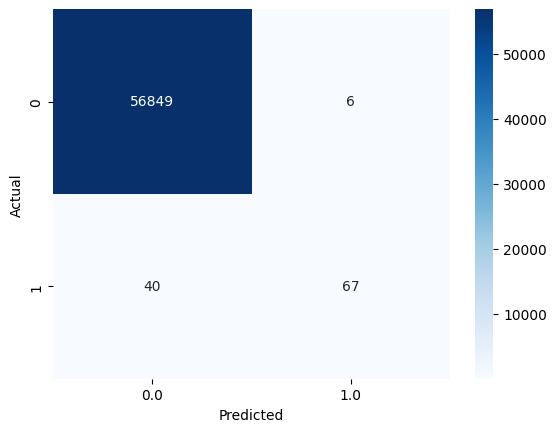

In [127]:
import seaborn as sns
confusion_matrix = pd.crosstab(y_test.values.T, y_pred.values.T, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True, cmap='Blues', fmt='g')